In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import multiprocessing

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Import the dataset that we will work with
cols = ['person_age', 'person_income', 'person_home_ownership',
        'person_emp_length', 'loan_intent', 'load_grade', 'loan_amnt',
        'loan_int_rate', 'loan_status', 'loan_percent_income',
        'cb_person_default_on_file', 'cb_person_cred_hist_length']
df = pd.read_csv('dataset_.csv', names= cols)
# Drop the first row as it contains coloumn names
df = df.iloc[1:]

In [4]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,load_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,22,59000,RENT,123,PERSONAL,D,35000,16.02,1,0.59,Y,3
2,21,9600,OWN,5,EDUCATION,B,1000,11.14,0,0.1,N,2
3,25,9600,MORTGAGE,1,MEDICAL,C,5500,12.87,1,0.57,N,3
4,23,65500,RENT,4,MEDICAL,C,35000,15.23,1,0.53,N,2
5,24,54400,RENT,8,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Check the structure and data types
print(df.info())

# Check for missing values
print("Missing Values in Each Column:")
print(df.isnull().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 1 to 32581
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   person_age                  32581 non-null  object
 1   person_income               32581 non-null  object
 2   person_home_ownership       32581 non-null  object
 3   person_emp_length           31686 non-null  object
 4   loan_intent                 32581 non-null  object
 5   load_grade                  32581 non-null  object
 6   loan_amnt                   32581 non-null  object
 7   loan_int_rate               29465 non-null  object
 8   loan_status                 32581 non-null  object
 9   loan_percent_income         32581 non-null  object
 10  cb_person_default_on_file   32581 non-null  object
 11  cb_person_cred_hist_length  32581 non-null  object
dtypes: object(12)
memory usage: 3.0+ MB
None
Missing Values in Each Column:
person_age                    

In [6]:
# Convert relevant columns to numeric, coercing errors to NaN (Not A Number)
for col in ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
            'loan_int_rate', 'loan_percent_income',
            'cb_person_cred_hist_length']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Replace missing values of employment length with median
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

# Replace interest rate missing values with median
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

In [7]:
# Check for missing values to make sure all missing values are now replaced
# the median
print("Missing Values in Each Column:")
print(df.isnull().sum())

Missing Values in Each Column:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
load_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [8]:
# Convert coloumns holding categoric data to category data type for appropriate
# handeling

categorical_cols = ['person_home_ownership', 'loan_intent', 'load_grade',
                    'cb_person_default_on_file']
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 1 to 32581
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  32581 non-null  int64   
 1   person_income               32581 non-null  int64   
 2   person_home_ownership       32581 non-null  category
 3   person_emp_length           32581 non-null  float64 
 4   loan_intent                 32581 non-null  category
 5   load_grade                  32581 non-null  category
 6   loan_amnt                   32581 non-null  int64   
 7   loan_int_rate               32581 non-null  float64 
 8   loan_status                 32581 non-null  object  
 9   loan_percent_income         32581 non-null  float64 
 10  cb_person_default_on_file   32581 non-null  category
 11  cb_person_cred_hist_length  32581 non-null  int64   
dtypes: category(4), float64(3), int64(4), object(1)
memory usage: 2.1+ MB


In [10]:
# A function that Replaces outliers in specified columns of a DataFrame with
# median
def replace_outliers_with_median(df, columns):
    for col in columns:
        # Calculate Q1 and Q3
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)

        # Calculate IQR
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        # Replace outliers with the median
        median_value = df[col].median()
        df.loc[outliers.index, col] = median_value
# Replacing the outliers in relative coloumns
columns_with_outliers = ['person_age', 'person_emp_length', 'loan_int_rate',
                         'person_income']
replace_outliers_with_median(df, columns_with_outliers)

In [11]:
from sklearn.preprocessing import LabelEncoder
# Make sure Loan status coloumn has only numerical values not strings
le = LabelEncoder()
df['loan_status'] = le.fit_transform(df['loan_status'])

# One-hot encode categorical variables to make them usable by the ML models
df = pd.get_dummies(df, columns= categorical_cols, drop_first=True)

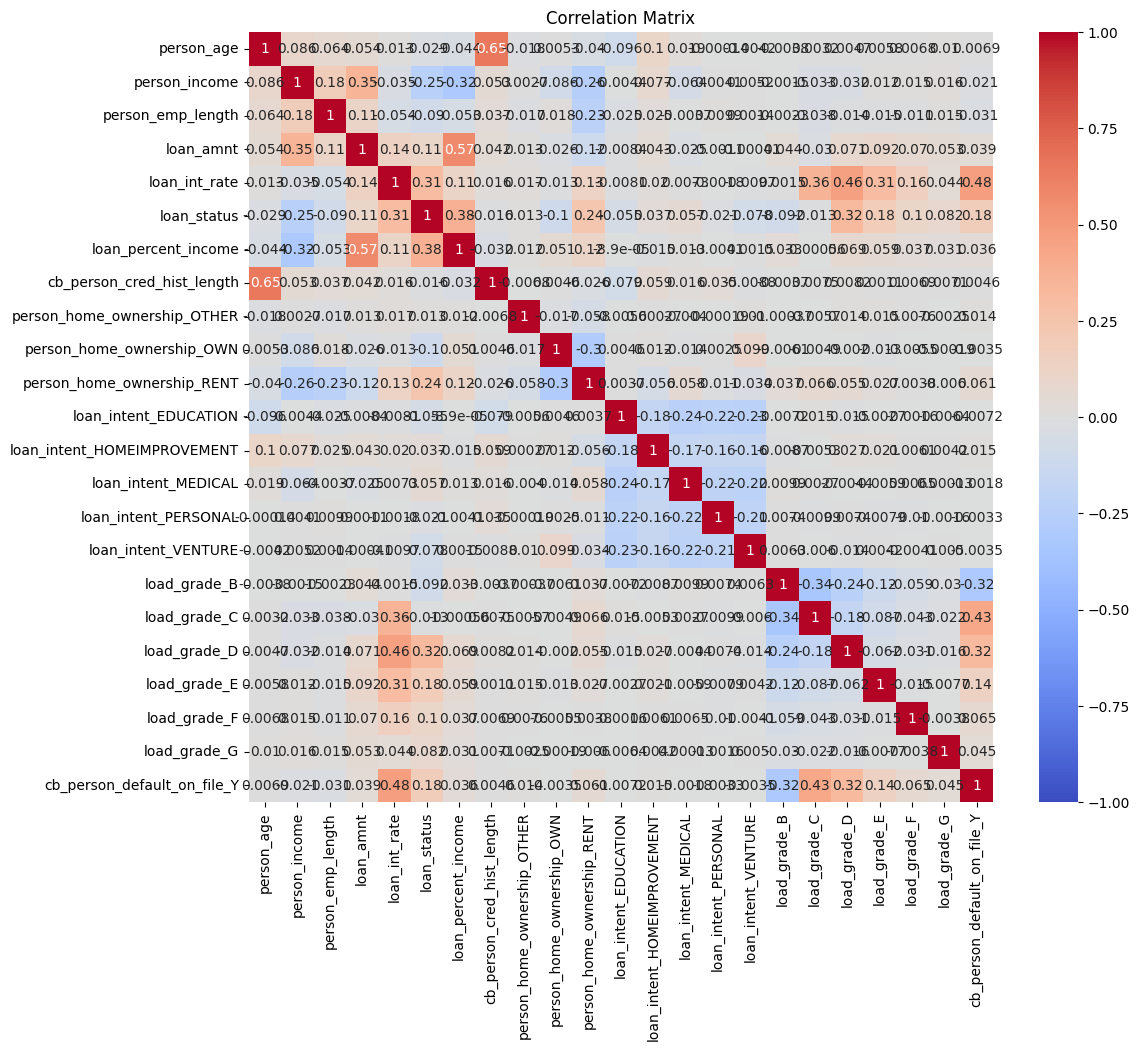

In [12]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [13]:
# Assigning X to all features but not the target, while assiging Y to be the
# target variable.
X = df.drop('loan_status', axis=1)
y = df['loan_status']
# Split the X and Y to have 25% as test data and 75% as training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=0)

In [14]:
from sklearn.preprocessing import StandardScaler
# Here we scale the data using standard scaler so the we do not have
# significant numerical difference between the values in each coloumn
scaler = StandardScaler()
# Training of scaled data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Define the hyperparameter grid for logistic regression

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
}

# Initialize the logistic regression model
model = LogisticRegression(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy',
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test_scaled)

print("Tuned Logistic Regression Results")
# Print out accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print out of data findings for evaluation
print("Best parameters:", grid_search.best_params_)
print("Logistic Regression average cross-validation score:",
      grid_search.best_score_)
print("\nLogistic Regression Classification Report:\n",
      classification_report(y_test, y_pred))



Tuned Logistic Regression Results
Accuracy: 0.8704885833537933
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression average cross-validation score: 0.8658072437077962

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      6482
           1       0.74      0.57      0.64      1664

    accuracy                           0.87      8146
   macro avg       0.82      0.76      0.78      8146
weighted avg       0.86      0.87      0.86      8146



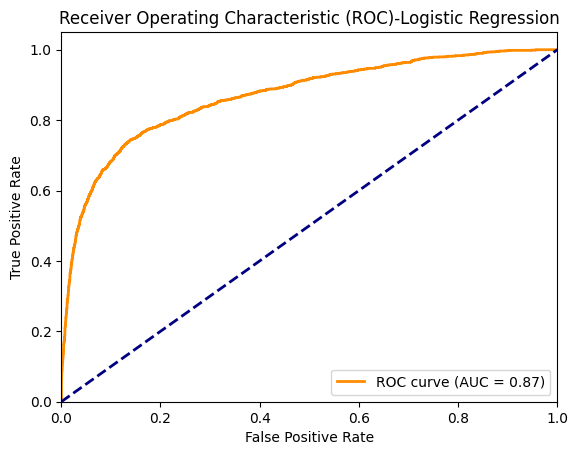

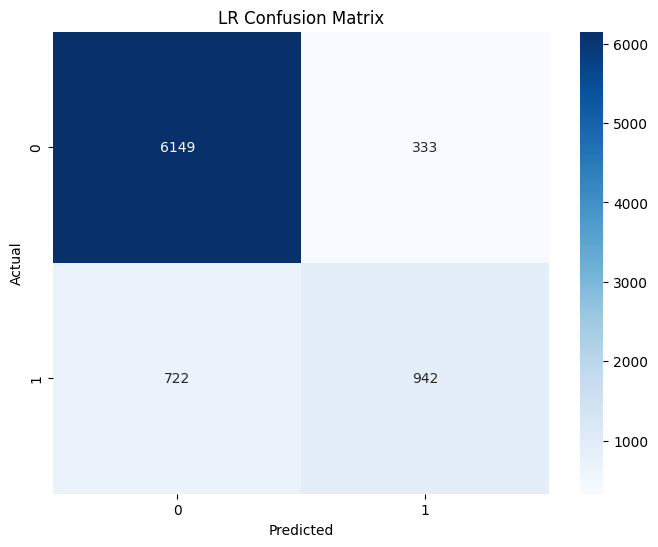


Model Overfittied/Underfitted/Balanced?
Model seems to be balanced


In [16]:
from sklearn.metrics import roc_curve, auc
# Probability of positive class
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)-Logistic Regression')
plt.legend(loc="lower right")
plt.show()


print("\n ")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Analyse the confusion matrix to determine overfitting/underfitting
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print("\nModel Overfittied/Underfitted/Balanced?")
# Determine overfitting/underfitting based on the metrics
if accuracy > 0.95 and (precision < 0.6 or recall < 0.6):
    print("Model might be overfitting")
elif accuracy < 0.6:
    print("Model might be underfitting")
else:
    print("Model seems to be balanced")

In [17]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
rf_model_tuned = RandomForestClassifier(random_state=0)

# Perform GridSearchCV for hyperparameter tuning
grid_search_rf = GridSearchCV(estimator=rf_model_tuned,
                              param_grid=param_grid_rf, cv=5,
                              scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search_rf.fit(X_train_scaled, y_train)

# Get the best model from the grid search
best_rf_model = grid_search_rf.best_estimator_

# Make predictions on the test set using the best model
rf_tuned_pred = best_rf_model.predict(X_test_scaled)

# Evaluate the tuned Random Forest model
print("\nTuned Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_tuned_pred))
print("\nTuned Random Forest Classification Report:")
print(classification_report(y_test, rf_tuned_pred))

print("Best parameters:", grid_search_rf.best_params_)
print("Tuned Random Forest average cross-validation score:",
      grid_search_rf.best_score_)


Tuned Random Forest Results:
Accuracy: 0.9329732383992143

Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6482
           1       0.95      0.71      0.81      1664

    accuracy                           0.93      8146
   macro avg       0.94      0.85      0.89      8146
weighted avg       0.93      0.93      0.93      8146

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Tuned Random Forest average cross-validation score: 0.9309187640679353


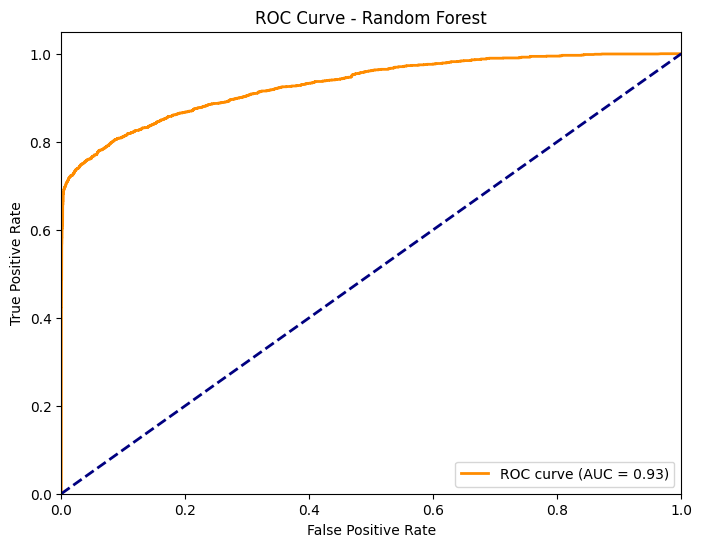

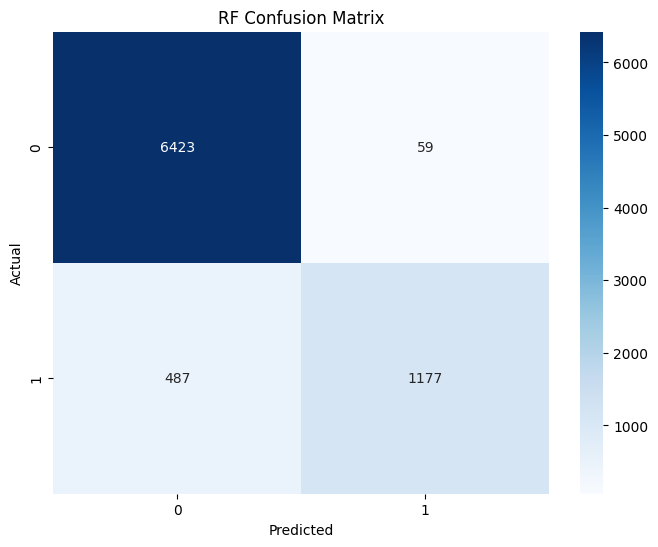


Model Overfittied/Underfitted/Balanced?
Model seems to be balanced


In [19]:
# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test,
                              best_rf_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange',
         lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

rf_pred = best_rf_model.predict(X_test_scaled) # Define rf_pred

print("\n")
cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Analysing the confusion matrix to determine if there is
# overfitting/underfitting for Random Forest model
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, rf_pred)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print("\nModel Overfittied/Underfitted/Balanced?")
# Determine overfitting/underfitting based on the metrics
if accuracy > 0.95 and (precision < 0.6 or recall < 0.6):
    print("Model might be overfitting")
elif accuracy < 0.6:
    print("Model might be underfitting.")
else:
    print("Model seems to be balanced")


In [16]:
# Define the parameter grid for Neural Network
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
}

# Initialize the Neural Network Classifier
nn_model_tuned = MLPClassifier(max_iter=len(df), random_state=42)

# Perform GridSearchCV for hyperparameter tuning
grid_search_nn = GridSearchCV(estimator=nn_model_tuned,
                             param_grid=param_grid_nn, cv=5,
                             scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search_nn.fit(X_train_scaled, y_train)

# Get the best model from the grid search
best_nn_model = grid_search_nn.best_estimator_

# Make predictions on the test set using the best model
nn_tuned_pred = best_nn_model.predict(X_test_scaled)

# Evaluate the tuned Neural Network model
print("\nTuned Neural Network Results:")
print("Accuracy:", accuracy_score(y_test, nn_tuned_pred))
print("\nTuned Neural Network Classification Report:")
print(classification_report(y_test, nn_tuned_pred))

print("Best parameters:", grid_search_nn.best_params_)
print("Tuned Neural Network average cross-validation score:",
      grid_search_nn.best_score_)


Tuned Neural Network Results:
Accuracy: 0.9224159096489074

Tuned Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      6482
           1       0.92      0.68      0.78      1664

    accuracy                           0.92      8146
   macro avg       0.92      0.83      0.87      8146
weighted avg       0.92      0.92      0.92      8146

Best parameters: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Tuned Neural Network average cross-validation score: 0.9197053406998158


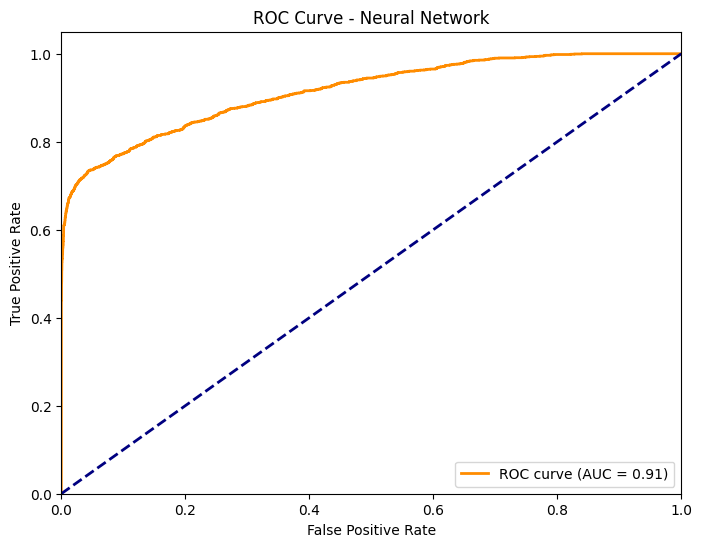

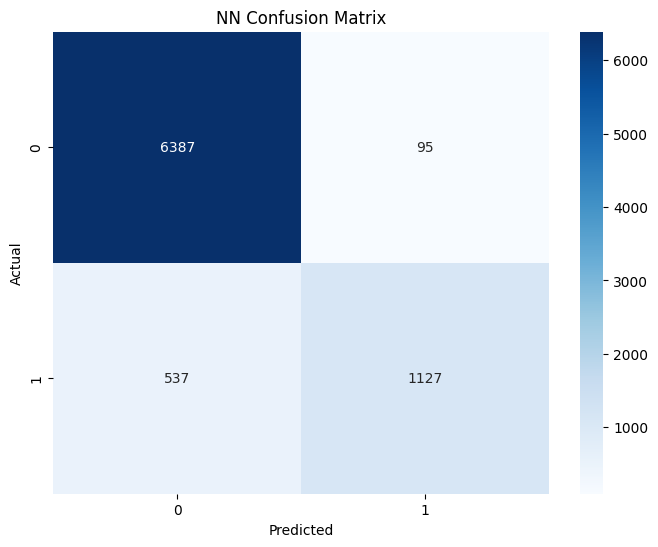

In [22]:
# ROC Curve for Tuned Neural Network model
fpr_nn, tpr_nn, _ = roc_curve(y_test,
                              best_nn_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, color='darkorange',
         lw=2, label=f'ROC curve (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend(loc="lower right")
plt.show()

nn_pred = best_nn_model.predict(X_test_scaled) # Define rf_pred

print("\n ")
cm = confusion_matrix(y_test, nn_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('NN Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()